In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, top_k_accuracy_score
# from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_loss_and_accuracy(history, session_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{session_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'{session_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.show()


def plot_confusion_matrix(model, X_test, y_test, session_name):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(true_classes, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(43), yticklabels=range(43))
    plt.title(f'{session_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



In [ ]:
data_s1 = pd.read_csv('/content/gdrive/MyDrive/EMG/Sessions/Session1.csv')
data_s2 = pd.read_csv('/content/gdrive/MyDrive/EMG/Sessions/Session2.csv')
data_s3 = pd.read_csv('/content/gdrive/MyDrive/EMG/Sessions/Session3.csv')

In [ ]:
sessions = {1: data_s1, 2: data_s2, 3: data_s3}

In [ ]:
sessions_num = [1, 2, 3]

## Single Cross-day Analysis

In [ ]:
import os
import functools
import keras

In [ ]:
def create_model():
    top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
    top3_acc.__name__ = 'top3_acc'
    model = Sequential()
    model.add(LSTM(128, input_shape=(33, 168),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(43, activation='softmax'))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy', top3_acc])
    return model

In [ ]:
checkpoint_path_sca = "/content/gdrive/MyDrive/EMG/Sessions/Checkpoints_LSTM_SCA_CV/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_sca)


keras_callbacks = [
        EarlyStopping(monitor='val_loss', verbose=1, patience=5),
        ModelCheckpoint(checkpoint_path_sca, monitor='val_loss', save_weights_only=True)
]

In [ ]:
def rank_k_accuracy(y_true, y_pred, k=3):
    top_k_preds = np.argsort(y_pred, axis=1)[:, -k:]
    success = 0
    for i in range(y_true.shape[0]):
        if y_true[i] in top_k_preds[i, :]:
            success += 1
    return success / y_true.shape[0]

In [ ]:
rank_3_accuracies = {}
rank_5_accuracies = {}

all_rank_3 = []
all_rank_5 = []

for repetition in range(1, 4):  # Repeating the analysis
    for fold in range(1, 8):  # Sevenfold cross-validation
        train_session = repetition
        test_trial = fold

        train_data = sessions[train_session]
        train_data = train_data.loc[train_data['Trial'] != test_trial]

        X_train = train_data.iloc[0:,3:]
        y_train = train_data.iloc[0:,0]

        test_data = pd.DataFrame()

        for session in sessions_num:
          if session != train_session:
            test_trial_data = sessions[session]
            test_data = test_data.append(test_trial_data.loc[test_trial_data['Trial'] == test_trial], ignore_index=True)

        X_test = test_data.iloc[0:,3:]
        y_test = test_data.iloc[0:,0]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        sequence_length = 33
        batch_size = 33
        X_batches_train_SCA = []
        y_batches_train_SCA = []
        X_batches_test_SCA = []
        y_batches_test_SCA = []

        for i in range(0, len(X_train) - sequence_length + 1, batch_size):
            X_batch = X_train.iloc[i:i+sequence_length]
            y_batch = y_train.iloc[i]

            X_batches_train_SCA.append(X_batch)
            y_batches_train_SCA.append(y_batch)

        from keras.utils import to_categorical
        y_batches_train_SCA = np.array(y_batches_train_SCA) - 1
        y_batches_train_SCA = to_categorical(y_batches_train_SCA)
        X_batches_train_SCA = np.array(X_batches_train_SCA)

        for i in range(0, len(X_test) - sequence_length + 1, batch_size):
            X_batch = X_test.iloc[i:i+sequence_length]
            y_batch = y_test.iloc[i]

            X_batches_test_SCA.append(X_batch)
            y_batches_test_SCA.append(y_batch)

        from keras.utils import to_categorical
        y_batches_test_SCA = np.array(y_batches_test_SCA) - 1
        y_batches_test_SCA = to_categorical(y_batches_test_SCA)
        X_batches_test_SCA = np.array(X_batches_test_SCA)

        # Create and compile the LSTM model
        model = create_model()

        # Train the model
        model.fit(X_batches_train_SCA, y_batches_train_SCA, epochs=35, batch_size=32, validation_data=(X_batches_test_SCA, y_batches_test_SCA), callbacks=keras_callbacks)

        # Evaluate the model
        metrics = model.evaluate(X_batches_test_SCA, y_batches_test_SCA)
        # Store and later average these metrics

        y_pred = model.predict(X_batches_test_SCA)

        # Calculate rank-k accuracy
        # accuracy_3 = rank_k_accuracy(np.argmax(y_batches_test_SCA, axis=1), y_pred, k=3)
        # rank_3_accuracies.append(accuracy_3)

        # accuracy_5 = rank_k_accuracy(np.argmax(y_batches_test_SCA, axis=1), y_pred, k=5)
        # rank_5_accuracies.append(accuracy_5)

        for class_label in range(y_pred.shape[1]):
            class_top3_correct = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(np.argmax(y_batches_test_SCA, axis=-1),  np.argsort(y_pred, axis=-1)[:, ::-1][:, :3])])
            rank_3_accuracies[class_label+1] = (np.sum(class_top3_correct)/34)

        all_rank_3.append(rank_3_accuracies)
        rank_3_accuracies = {}

        for class_label in range(y_pred.shape[1]):
            class_top3_correct = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(np.argmax(y_batches_test_SCA, axis=-1),  np.argsort(y_pred, axis=-1)[:, ::-1][:, :5])])
            rank_5_accuracies[class_label+1] = (np.sum(class_top3_correct)/34)

        all_rank_5.append(rank_5_accuracies)
        rank_5_accuracies = {}

In [ ]:
def calculate_means(dict_list):
    # Initialize a dictionary to hold the sum of values for each key
    sums = {key: 0 for key in dict_list[0].keys()}

    # Iterate over each dictionary and sum up the values for each key
    for d in dict_list:
        for key, value in d.items():
            sums[key] += (value*100)

    # Calculate the mean for each key
    means = {key: value / len(dict_list) for key, value in sums.items()}

    return means

In [ ]:
means_SCD = calculate_means(all_rank_5)

In [ ]:
acc_5 = list(means_SCD.values())

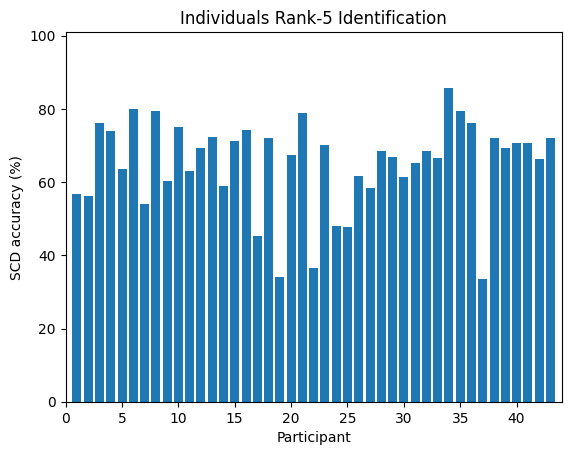

In [ ]:
plt.bar(range(1,44), acc_5)

plt.xlim(0,44)
plt.ylim(0,101)
plt.title('Individuals Rank-5 Identification')
plt.ylabel('SCD accuracy (%)')
plt.xlabel('Participant')
plt.show()

### Trial

In [ ]:
train_session = 1
test_trial = 7

In [ ]:
train_data = sessions[train_session]
train_data = train_data.loc[train_data['Trial'] != test_trial]

X_train = train_data.iloc[0:,3:]
y_train = train_data.iloc[0:,0]

In [ ]:
test_data = pd.DataFrame()

for session in sessions_num:
  if session != train_session:
    test_trial_data = sessions[session]
    test_data = test_data.append(test_trial_data.loc[test_trial_data['Trial'] == test_trial], ignore_index=True)

X_test = test_data.iloc[0:,3:]
y_test = test_data.iloc[0:,0]

<ipython-input-63-a232c9e086f1>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(test_trial_data.loc[test_trial_data['Trial'] == test_trial], ignore_index=True)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
sequence_length = 33
batch_size = 33
X_batches_train_SCA = []
y_batches_train_SCA = []
X_batches_test_SCA = []
y_batches_test_SCA = []

In [ ]:
for i in range(0, len(X_train) - sequence_length + 1, batch_size):
  X_batch = X_train.iloc[i:i+sequence_length]
  y_batch = y_train.iloc[i]

  X_batches_train_SCA.append(X_batch)
  y_batches_train_SCA.append(y_batch)

from keras.utils import to_categorical
y_batches_train_SCA = np.array(y_batches_train_SCA) - 1
y_batches_train_SCA = to_categorical(y_batches_train_SCA)
X_batches_train_SCA = np.array(X_batches_train_SCA)

In [ ]:
for i in range(0, len(X_test) - sequence_length + 1, batch_size):
  X_batch = X_test.iloc[i:i+sequence_length]
  y_batch = y_test.iloc[i]

  X_batches_test_SCA.append(X_batch)
  y_batches_test_SCA.append(y_batch)

from keras.utils import to_categorical
y_batches_test_SCA = np.array(y_batches_test_SCA) - 1
y_batches_test_SCA = to_categorical(y_batches_test_SCA)
X_batches_test_SCA = np.array(X_batches_test_SCA)

In [ ]:
import os
import functools
import keras

In [ ]:
checkpoint_path_sca = "/content/gdrive/MyDrive/EMG/Sessions/Checkpoints_LSTM_SCA/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_sca)

In [ ]:
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(33, 168),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(43, activation='softmax'))

adam = Adam(learning_rate=0.0001)
keras_callbacks = [
    EarlyStopping(monitor='val_loss', verbose=1, patience=10),
    ModelCheckpoint(checkpoint_path_sca, monitor='val_loss', save_weights_only=True)
]
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy', top3_acc])
model.summary()

In [ ]:
history_sca_lstm = model.fit(X_batches_train, y_batches_train, epochs=100, batch_size=32, validation_data=(X_batches_test, y_batches_test), callbacks=keras_callbacks)

In [ ]:
true_classes_SCA = np.argmax(y_batches_test_SCA, axis=-1)

predicted_classes = np.argmax(model.predict(X_batches_test_SCA), axis=-1)
accuracy = accuracy_score(true_classes, predicted_classes)
# accuracy_3 = top_k_accuracy_score(true_classes, predicted_classes, k=3)
# accuracy_5 = top_k_accuracy_score(true_classes, predicted_classes, k=5)
print(f'Accuracy: {accuracy*100:.2f}%')
# print(f'Accuracy: {accuracy_3*100:.2f}%')
# print(f'Accuracy: {accuracy_5*100:.2f}%')
report = classification_report(true_classes_SCA, predicted_classes)
print(report)

In [ ]:
with open('/content/gdrive/MyDrive/EMG/Sessions/single_cross_lstm1_es.pkl', 'wb') as file:
    pickle.dump(history_sca_lstm.history, file)

In [ ]:
with open('/content/gdrive/MyDrive/EMG/Sessions/single_cross_lstm1_es.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
plot_loss_and_accuracy(history, 'Single Cross Day')

In [ ]:
plot_confusion_matrix(model, X_batches_test_SCA, y_batches_test_SCA, 'Single Cross Day')

In [ ]:
y_pred_SCA = model.predict(X_batches_test_SCA)
y_pred_labels_SCA = np.argmax(y_pred_SCA, axis=1)
true_classes = np.argmax(y_batches_test_SCA, axis=1)

cm_SCA = confusion_matrix(true_classes, y_pred_labels_SCA)

In [ ]:
FP_SCA = cm_SCA.sum(axis=0) - np.diag(cm_SCA)
TP_SCA = np.diag(cm_SCA)

In [ ]:
TP_SCA

In [ ]:
df = pd.DataFrame({'True Positive':TP_SCA,
                  'False Positive':FP_SCA})

df = df.astype(int)
df.plot.bar(stacked=True)

In [ ]:
model.summary()

In [ ]:
for y_true, sorted_pred in zip(y_batches_test_SCA, sorted_predictions):
  print(sorted_pred)

In [ ]:
predictions = model.predict(X_batches_test_SCA)
predicted_classes = np.argmax(model.predict(X_batches_test_SCA), axis=-1)
accuracy = accuracy_score(true_classes, predicted_classes)
# accuracy_3 = top_k_accuracy_score(true_classes, predicted_classes, k=3)
# accuracy_5 = top_k_accuracy_score(true_classes, predicted_classes, k=5)
print(f'Accuracy: {accuracy*100:.2f}%')
# print(f'Accuracy: {accuracy_3*100:.2f}%')
# print(f'Accuracy: {accuracy_5*100:.2f}%')
report = classification_report(true_classes, predicted_classes)
print(report)

In [ ]:
predictions = model.predict(X_batches_test_SCA)

top5_indices = np.argsort(predictions, axis=-1)[:, ::-1][:, :5]

# Check if the true class is among the top 5 predicted classes
top5_correct = np.array([y_true in top5 for y_true, top5 in zip(true_classes_SCA, top5_indices)])

# Calculate top-5 accuracy
top5_accuracy = np.mean(top5_correct)

print(top5_accuracy*100)

In [ ]:
class_rank5_accuracy = {}

for class_label in range(predictions.shape[1]):
    class_top5_correct = np.array([y_true == class_label and class_label in top5 for y_true, top5 in zip(true_classes_SCA, top5_indices)])
    # print(len(class_top5_correct))
    class_rank5_accuracy[class_label+1] = (np.sum(class_top5_correct)/34)*100

for class_label, accuracy in class_rank5_accuracy.items():
    print(f"Class {class_label} Rank-5 Accuracy: {accuracy}")

In [ ]:
acc_5 = list(class_rank5_accuracy.values())

In [ ]:
plt.bar(range(1,44), acc_5)

plt.xlim(0,44)
plt.ylim(0,101)
plt.title('Individuals Rank-5 Identification')
plt.ylabel('SCD accuracy (%)')
plt.xlabel('Participant')
plt.show()

In [ ]:
predictions = model.predict(X_batches_test_SCA)

top3_indices = np.argsort(predictions, axis=-1)[:, ::-1][:, :3]

# Check if the true class is among the top 5 predicted classes
top3_correct = np.array([y_true in top3 for y_true, top3 in zip(true_classes_SCA, top3_indices)])

# Calculate top-5 accuracy
top3_accuracy = np.mean(top3_correct)

print(top3_accuracy*100)

In [ ]:
class_rank3_accuracy = {}

for class_label in range(predictions.shape[1]):
    class_top3_correct = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(true_classes_SCA, top3_indices)])

    class_rank3_accuracy[class_label+1] = (np.sum(class_top3_correct)/34)*100

for class_label, accuracy in class_rank3_accuracy.items():
    print(f"Class {class_label} Rank-3 Accuracy: {accuracy}")

In [ ]:
acc_3 = list(class_rank3_accuracy.values())

In [ ]:
plt.bar(range(1,44), acc_3)

## Cumulative Cross-Day

In [ ]:
checkpoint_path_sca = "/content/gdrive/MyDrive/EMG/Sessions/Checkpoints_LSTM_CCA_CV/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_sca)


keras_callbacks = [
        EarlyStopping(monitor='val_loss', verbose=1, patience=5),
        ModelCheckpoint(checkpoint_path_sca, monitor='val_loss', save_weights_only=True)
]

In [ ]:
rank_3_accuracies = {}
rank_5_accuracies = {}

all_rank_3 = []
all_rank_5 = []

for repetition in range(1, 4):  # Repeating the analysis
    for fold in range(1, 8):  # Sevenfold cross-validation
        test_session = repetition
        test_trial = fold

        train_data = pd.DataFrame()

        for session in sessions_num:
          if session != test_session:
            test_trial_data = sessions[session]
            train_data = train_data.append(test_trial_data.loc[test_trial_data['Trial'] != test_trial], ignore_index=True)

        X_train = train_data.iloc[0:,3:]
        y_train = train_data.iloc[0:,0]

        test_data = sessions[test_session]
        test_data = test_data.loc[test_data['Trial'] == test_trial]

        X_test = test_data.iloc[0:,3:]
        y_test = test_data.iloc[0:,0]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        sequence_length = 33
        batch_size = 33
        X_batches_train_CCA = []
        y_batches_train_CCA = []
        X_batches_test_CCA = []
        y_batches_test_CCA = []

        for i in range(0, len(X_train) - sequence_length + 1, batch_size):
          X_batch = X_train.iloc[i:i+sequence_length]
          y_batch = y_train.iloc[i]

          X_batches_train_CCA.append(X_batch)
          y_batches_train_CCA.append(y_batch)

        from keras.utils import to_categorical
        y_batches_train_CCA = np.array(y_batches_train_CCA) - 1
        y_batches_train_CCA = to_categorical(y_batches_train_CCA)
        X_batches_train_CCA = np.array(X_batches_train_CCA)

        for i in range(0, len(X_test) - sequence_length + 1, batch_size):
          X_batch = X_test.iloc[i:i+sequence_length]
          y_batch = y_test.iloc[i]

          X_batches_test_CCA.append(X_batch)
          y_batches_test_CCA.append(y_batch)

        from keras.utils import to_categorical
        y_batches_test_CCA = np.array(y_batches_test_CCA) - 1
        y_batches_test_CCA = to_categorical(y_batches_test_CCA)
        X_batches_test_CCA = np.array(X_batches_test_CCA)

        # Create and compile the LSTM model
        model = create_model()

        # Train the model
        model.fit(X_batches_train_CCA, y_batches_train_CCA, epochs=35, batch_size=32, validation_data=(X_batches_test_CCA, y_batches_test_CCA), callbacks=keras_callbacks)

        # Evaluate the model
        metrics = model.evaluate(X_batches_test_CCA, y_batches_test_CCA)
        # Store and later average these metrics

        y_pred = model.predict(X_batches_test_CCA)

        for class_label in range(y_pred.shape[1]):
            class_top3_correct = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(np.argmax(y_batches_test_SCA, axis=-1),  np.argsort(y_pred, axis=-1)[:, ::-1][:, :3])])
            rank_3_accuracies[class_label+1] = (np.sum(class_top3_correct)/17)

        all_rank_3.append(rank_3_accuracies)
        rank_3_accuracies = {}

        for class_label in range(y_pred.shape[1]):
            class_top3_correct = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(np.argmax(y_batches_test_SCA, axis=-1),  np.argsort(y_pred, axis=-1)[:, ::-1][:, :5])])
            rank_5_accuracies[class_label+1] = (np.sum(class_top3_correct)/17)

        all_rank_5.append(rank_5_accuracies)
        rank_5_accuracies = {}

In [ ]:
means_SCD = calculate_means(all_rank_5)

In [ ]:
acc_5 = list(means_SCD.values())

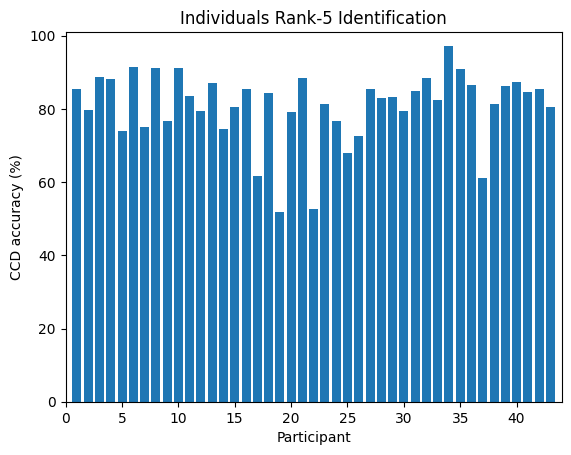

In [ ]:
plt.bar(range(1,44), acc_5)

plt.xlim(0,44)
plt.ylim(0,101)
plt.title('Individuals Rank-5 Identification')
plt.ylabel('CCD accuracy (%)')
plt.xlabel('Participant')
plt.show()

### Trial

In [ ]:
test_session = 3
test_trial = 7

In [ ]:
train_data = pd.DataFrame()

for session in sessions_num:
  if session != test_session:
    test_trial_data = sessions[session]
    train_data = train_data.append(test_trial_data.loc[test_trial_data['Trial'] != test_trial], ignore_index=True)

X_train = train_data.iloc[0:,3:]
y_train = train_data.iloc[0:,0]

In [ ]:
test_data = sessions[test_session]
test_data = test_data.loc[test_data['Trial'] == test_trial]

X_test = test_data.iloc[0:,3:]
y_test = test_data.iloc[0:,0]

In [ ]:
test_data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
sequence_length = 33
batch_size = 33
X_batches_train = []
y_batches_train = []
X_batches_test = []
y_batches_test = []

In [ ]:
for i in range(0, len(X_train) - sequence_length + 1, batch_size):
  X_batch = X_train.iloc[i:i+sequence_length]
  y_batch = y_train.iloc[i]

  X_batches_train.append(X_batch)
  y_batches_train.append(y_batch)

from keras.utils import to_categorical
y_batches_train = np.array(y_batches_train) - 1
y_batches_train = to_categorical(y_batches_train)
X_batches_train = np.array(X_batches_train)

In [ ]:
for i in range(0, len(X_test) - sequence_length + 1, batch_size):
  X_batch = X_test.iloc[i:i+sequence_length]
  y_batch = y_test.iloc[i]

  X_batches_test.append(X_batch)
  y_batches_test.append(y_batch)

from keras.utils import to_categorical
y_batches_test = np.array(y_batches_test) - 1
y_batches_test = to_categorical(y_batches_test)
X_batches_test = np.array(X_batches_test)

In [ ]:
y_batches_test.shape

In [ ]:
checkpoint_path_cca = "/content/gdrive/MyDrive/EMG/Sessions/Checkpoints_LSTM_CCA/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_cca)

In [ ]:
model_CCA = Sequential()
model_CCA.add(LSTM(128, input_shape=(33, 168),return_sequences=True))
model_CCA.add(Dropout(0.2))
model_CCA.add(LSTM(64))
model_CCA.add(Dropout(0.2))
model_CCA.add(Dense(43, activation='softmax'))

adam = Adam(learning_rate=0.0001)
keras_callbacks = [
    EarlyStopping(monitor='val_loss', verbose=1, patience=10),
    ModelCheckpoint(checkpoint_path_cca, monitor='val_loss', save_weights_only=True)
]
model_CCA.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy', top3_acc])
model_CCA.summary()

In [ ]:
history_cca_lstm = model_CCA.fit(X_batches_train, y_batches_train, epochs=100, batch_size=32, validation_data=(X_batches_test, y_batches_test), callbacks=keras_callbacks)

In [ ]:
true_classes = np.argmax(y_batches_test, axis=-1)

predicted_classes = np.argmax(model_CCA.predict(X_batches_test), axis=-1)
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy*100:.2f}%')
report = classification_report(true_classes, predicted_classes)
print(report)

In [ ]:
with open('/content/gdrive/MyDrive/EMG/Sessions/cumulative_cross_lstm1_es.pkl', 'wb') as file:
    pickle.dump(history_cca_lstm.history, file)

In [ ]:
with open('/content/gdrive/MyDrive/EMG/Sessions/cumulative_cross_lstm1_es.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
plot_loss_and_accuracy(history, 'Cumulative Cross Day')

In [ ]:
plot_confusion_matrix(model_CCA, X_batches_test, y_batches_test, 'Cumulative Cross Day')

In [ ]:
y_pred = model_CCA.predict(X_batches_test)
y_pred_labels = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_batches_test, axis=1)

cm = confusion_matrix(true_classes, y_pred_labels)

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)
TP = np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)

In [ ]:
df = pd.DataFrame({'True Positive':TP,
                  'False Positive':FP})

df = df.astype(int)
df.plot.bar(stacked=True)

In [ ]:
predictions_CCA = model_CCA.predict(X_batches_test)

top5_indices_CCA = np.argsort(predictions_CCA, axis=-1)[:, ::-1][:, :5]

# Check if the true class is among the top 5 predicted classes
top5_correct_CCA = np.array([y_true in top5 for y_true, top5 in zip(true_classes, top5_indices_CCA)])

# Calculate top-5 accuracy
top5_accuracy_CCA = np.mean(top5_correct_CCA)

print(top5_accuracy_CCA*100)

In [ ]:
class_rank5_accuracy_CCA = {}

for class_label in range(predictions_CCA.shape[1]):
    class_top5_correct_CCA = np.array([y_true == class_label and class_label in top5 for y_true, top5 in zip(true_classes, top5_indices_CCA)])
    # print(len(class_top5_correct_CCA))
    class_rank5_accuracy_CCA[class_label+1] = (np.sum(class_top5_correct_CCA)/17)*100

for class_label, accuracy in class_rank5_accuracy_CCA.items():
    print(f"Class {class_label} Rank-5 Accuracy: {accuracy}")

In [ ]:
acc_5_CCA = list(class_rank5_accuracy_CCA.values())

In [ ]:
plt.bar(range(1,44), acc_5_CCA)

plt.xlim(0,44)
plt.ylim(0,101)
plt.title('Individuals Rank-5 Identification')
plt.ylabel('CCD accuracy (%)')
plt.xlabel('Participant')
plt.show()

In [ ]:
predictions_CCA = model_CCA.predict(X_batches_test)

top3_indices_CCA = np.argsort(predictions_CCA, axis=-1)[:, ::-1][:, :3]

# Check if the true class is among the top 5 predicted classes
top3_correct_CCA = np.array([y_true in top3 for y_true, top3 in zip(true_classes, top3_indices_CCA)])

# Calculate top-5 accuracy
top3_accuracy_CCA = np.mean(top3_correct_CCA)

print(top3_accuracy_CCA*100)

In [ ]:
class_rank3_accuracy_CCA = {}

for class_label in range(predictions_CCA.shape[1]):
    class_top3_correct_CCA = np.array([y_true == class_label and class_label in top3 for y_true, top3 in zip(true_classes, top3_indices_CCA)])

    class_rank3_accuracy_CCA[class_label+1] = (np.sum(class_top3_correct_CCA)/17)*100

for class_label, accuracy in class_rank3_accuracy_CCA.items():
    print(f"Class {class_label} Rank-3 Accuracy: {accuracy}")

In [ ]:
acc_3_CCA = list(class_rank3_accuracy_CCA.values())

In [ ]:
plt.bar(range(1,44), acc_3_CCA)